# Distance Analysis

#### Get Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine_vector
import seaborn as sns

# Define functions
def get_distance_between_rows(df):
    """
    Calculate the Haversine distance between consecutive rows in a DataFrame (in kilometers)
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'latitude' and 'longitude' columns.
    Returns:
    numpy.ndarray: Array of distances between consecutive rows.
    """
    
    coords1 = df[['latitude', 'longitude']].values[:-1]
    coords2 = df[['latitude', 'longitude']].values[1:]
    distances = haversine_vector(coords1, coords2)
    return distances

# check
def get_time_between_rows(df):
    """
    Calculate the time difference between consecutive rows in a DataFrame (in hours)
    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'datetime' column with date and time information.
    Returns: numpy.ndarray: Array of time differences between consecutive rows.
    """

    date = pd.to_datetime(df['datetime'])
    datetime1 = date.values[:-1]
    datetime2 = date.values[1:]
    difference = (datetime2 - datetime1).astype('timedelta64[s]')
    getHours = np.vectorize(lambda x: x / np.timedelta64(1, 'h'))
    return getHours(difference)

In [ ]:
# Load the data
file_path = '../../data/movements.csv'
movements_data = pd.read_csv(file_path, parse_dates=['datetime'])

In [ ]:
# get distance and time between each measurement
grouped = movements_data.groupby('id')
distance_dict = {}
time_dict = {}

for name, group in grouped:
    distances = get_distance_between_rows(group)
    times = get_time_between_rows(group)
    distance_dict[name] = distances
    time_dict[name] = times

# replaces missing items w/ NaN
distance_results = pd.DataFrame({ key:pd.Series(value) for key, value in distance_dict.items() })
time_results = pd.DataFrame({ key:pd.Series(value) for key, value in time_dict.items() })

In [ ]:
# get velocity
velocity_results = distance_results / time_results
velocity_results.columns = [f'Velocity_{col}' for col in velocity_results.columns]

In [43]:
# get low movement
LOW_MOVEMENT_BOUND = 1 / 1000
low_movement = pd.DataFrame()
for col in distance_results.columns:
    low_movement[col] = pd.Series([distance for distance in distance_results[col] if distance < LOW_MOVEMENT_BOUND])

#### Missing Values

In [ ]:
missing_movement_data = pd.DataFrame()
missing_movement_data['latitude'] = grouped['latitude'].apply(lambda x: x.isna().sum())
missing_movement_data['longitude'] = grouped['latitude'].apply(lambda x: x.isna().sum())

missing_movement_data.head(10)

In [ ]:
# verify all missing values are due to lengths
length = distance_results.notna().sum().reset_index()
length.columns = ['id', 'length']
length['distance_from_max'] = length['length'] - length['length'].max()

length['distance_results_na'] = distance_results.isna().sum().values
length['time_results_na'] = time_results.isna().sum().values

length.head(10)


In [ ]:
print(distance_results.apply(lambda x: x.isna().sum()))
print(time_results.apply(lambda x: x.isna().sum()))

#### Summary Stats

In [22]:
distance_results.apply(lambda x: x.describe())

,I000,I001,I002,I003,I004,I005,I006,I007,I008,I009
count,526300.000000,525744.000000,526179.000000,526590.000000,526237.000000,525836.000000,526183.000000,526329.000000,526491.000000,526169.000000
mean,0.447801,0.447053,0.450112,0.448800,0.446899,0.447842,0.445090,0.445122,0.446202,0.449108
std,2.106352,2.103911,2.115942,2.106321,2.101657,2.108986,2.099712,2.096921,2.105516,2.112365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007826,0.007840,0.007851,0.007885,0.007856,0.007836,0.007830,0.007842,0.007820,0.007848
50%,0.021372,0.021395,0.021429,0.021470,0.021463,0.021461,0.021362,0.021412,0.021409,0.021396
75%,0.043440,0.043440,0.043450,0.043556,0.043423,0.043477,0.043323,0.043410,0.043420,0.043414
max,22.930729,22.805757,22.757470,22.681763,22.844746,22.878719,22.675153,22.845531,22.639446,22.770844


In [ ]:
velocity_results.apply(lambda x: x.describe())

#### Sleep

In [44]:
def longest_stretch_no_movement(df, threshold, movements_data):
    """input in seconds and km"""
    longest_stretch = {}
    stretch_timestamps = {}
    stretch_durations = {}
    
    for col in df.columns:
        small_movement = df[col] < threshold
        max_stretch = 0
        current_stretch = 0
        start_index = 0
        end_index = 0
        
        for i, movement in enumerate(small_movement):
            if movement:
                if current_stretch == 0:
                    current_start_index = i
                current_stretch += 1
            else:
                if current_stretch > max_stretch:
                    max_stretch = current_stretch
                    start_index = current_start_index
                    end_index = i - 1
                current_stretch = 0
        
        # Check the last stretch
        if current_stretch > max_stretch:
            max_stretch = current_stretch
            start_index = current_start_index
            end_index = len(small_movement) - 1
        
        longest_stretch[col] = max_stretch
        start_time = movements_data.iloc[start_index]['datetime']
        end_time = movements_data.iloc[end_index]['datetime']
        stretch_timestamps[col] = (start_time, end_time)
        stretch_durations[col] = (end_time - start_time).total_seconds() / 3600  # duration in hours
    
    return longest_stretch, stretch_timestamps, stretch_durations

# Find the longest stretch of no movement for each individual, their timestamps, and durations
longest_stretch_no_movement_results, stretch_timestamps, stretch_durations = longest_stretch_no_movement(distance_results, LOW_MOVEMENT_BOUND, movements_data)

# Turn the results into a DataFrame
longest_stretch_df = pd.DataFrame({
    'Longest Stretch (no movement)': longest_stretch_no_movement_results,
    'Start Time': {k: v[0] for k, v in stretch_timestamps.items()},
    'End Time': {k: v[1] for k, v in stretch_timestamps.items()},
    'Duration (hours)': stretch_durations
})

longest_stretch_df.head(10)

,Longest Stretch (no movement),Start Time,End Time,Duration (hours)
I000,10,2020-02-09 12:30:45,2020-02-09 12:39:26,0.144722
I001,16,2020-07-29 23:36:57,2020-07-29 23:50:56,0.233056
I002,12,2020-11-24 11:19:55,2020-11-24 11:30:22,0.174167
I003,9,2020-03-23 06:55:53,2020-03-23 07:05:55,0.167222
I004,10,2020-05-01 12:59:09,2020-05-01 13:06:16,0.118611
I005,11,2020-02-02 15:06:40,2020-02-02 15:17:57,0.188056
I006,15,2020-06-05 11:40:01,2020-06-05 11:53:14,0.220278
I007,11,2020-02-12 00:10:14,2020-02-12 00:20:00,0.162778
I008,12,2020-05-05 08:11:57,2020-05-05 08:22:24,0.174167
I009,10,2020-02-03 17:08:44,2020-02-03 17:17:53,0.152500


#### Graphs

##### Velocity Over Time

In [ ]:
n_1 = 1
n_2 = 1
# Plot the velocity results for each id in separate graphs with downsampling and rolling averages
for col in velocity_results.columns:
    plt.figure(figsize=(10, 3))
    
    # first 10,000 points
    downsampled_data = velocity_results[col].iloc[:10000:]
    
    # Calculate rolling average with a window of 1000 points
    # rolling_avg = velocity_results[col].rolling(window=n_2).mean()
    
    plt.plot(downsampled_data.index, downsampled_data, linestyle='-', label=f'{col}')
    # plt.plot(rolling_avg.index, rolling_avg, linestyle='-', color='red', label=f'{col} (Rolling Avg)')
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Velocity (km/hr)')
    plt.title(f'Velocity Over Time for {col}')
    plt.legend()
    
    # Show the plot
    plt.show()

##### Movement Distributions

In [ ]:
for col in distance_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot(distance_results[col], bins=100, log_scale=(True, False))

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col}(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

In [ ]:
for col in distance_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot([distance for distance in distance_results[col] if distance > 10], bins=100, log_scale=(True, False))
    

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col} > 10(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

In [ ]:
for col in distance_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot([distance for distance in distance_results[col] if distance < 3], bins=100, log_scale=(True, False))
    

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col} > 10(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

##### Velocity Distributions

In [ ]:
for col in velocity_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot(velocity_results[col], bins=100, log_scale=(True, False))

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col}(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

##### Stillness

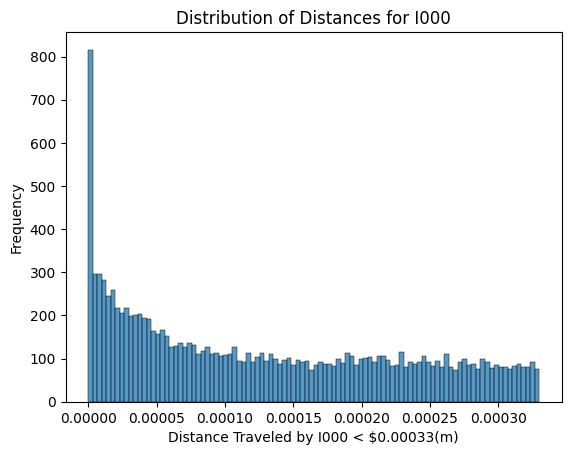

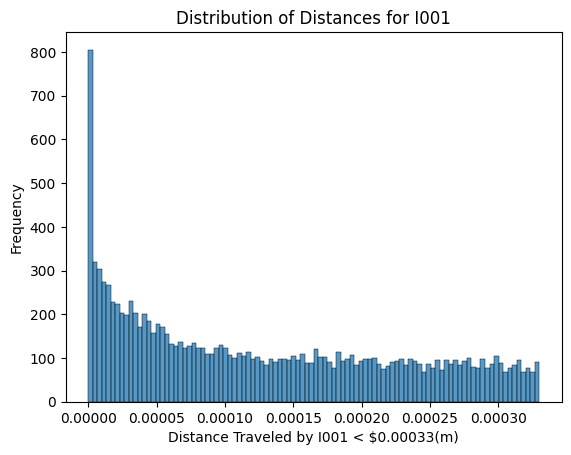

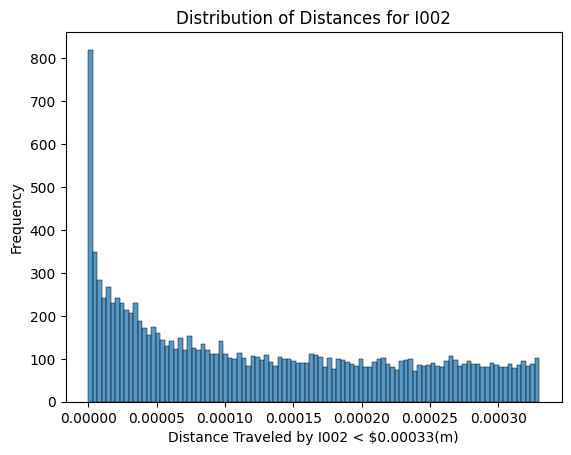

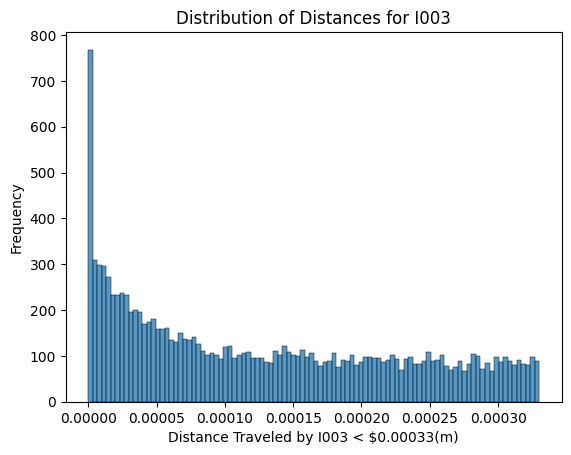

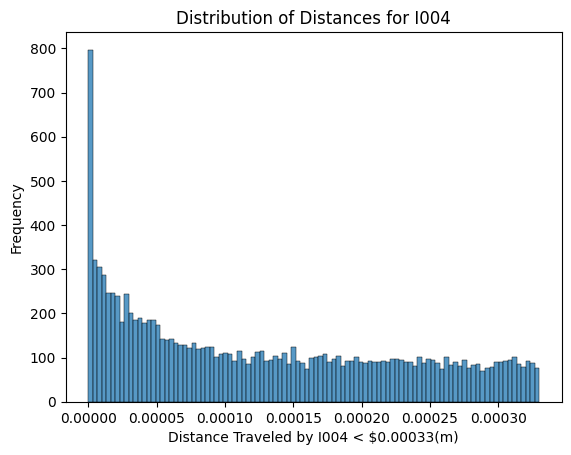

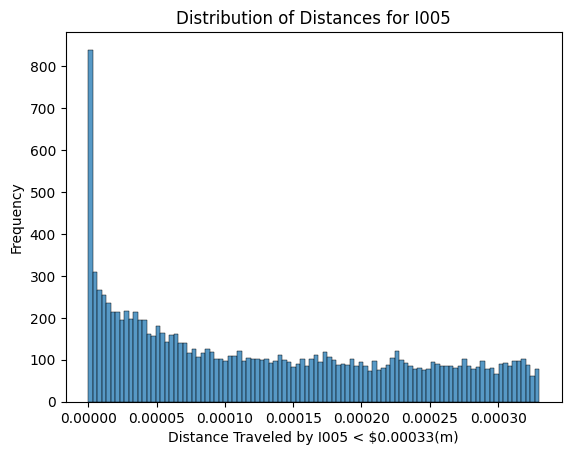

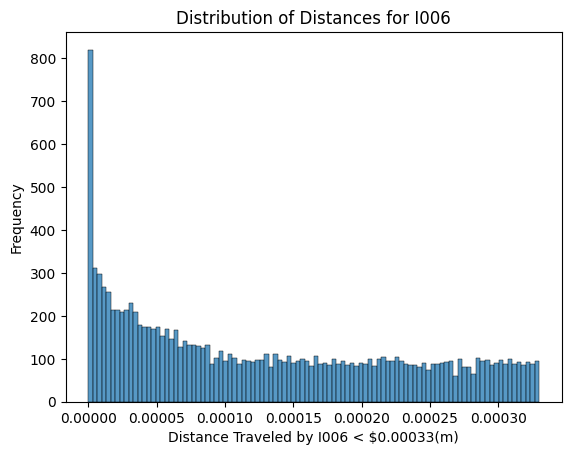

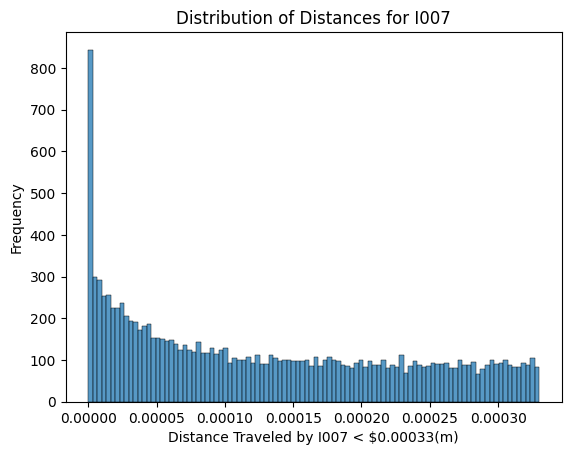

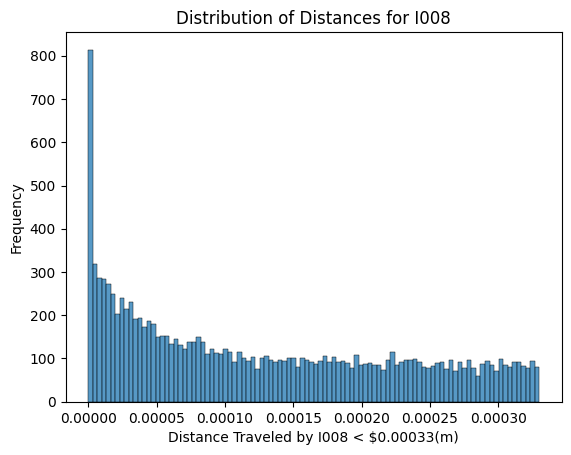

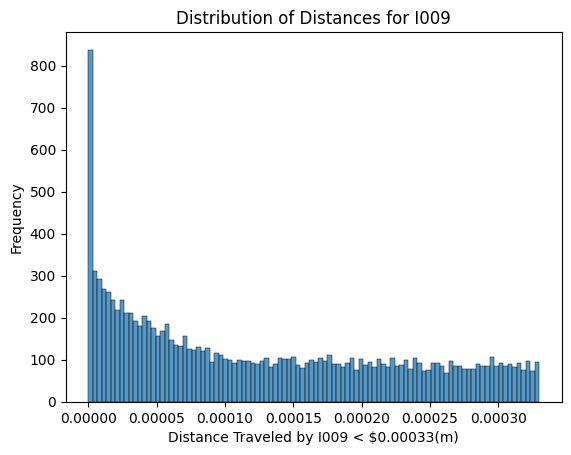

In [35]:
for col in low_movement.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot([distance for distance in low_movement[col]], bins=100)
    

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col} < ${LOW_MOVEMENT_BOUND}(m)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()